In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
cd gdrive/'My Drive'/'Computer Vision/Final Project'

/content/gdrive/My Drive/Computer Vision/Final Project


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter

# Pose Estimation

## Image Preprocessing

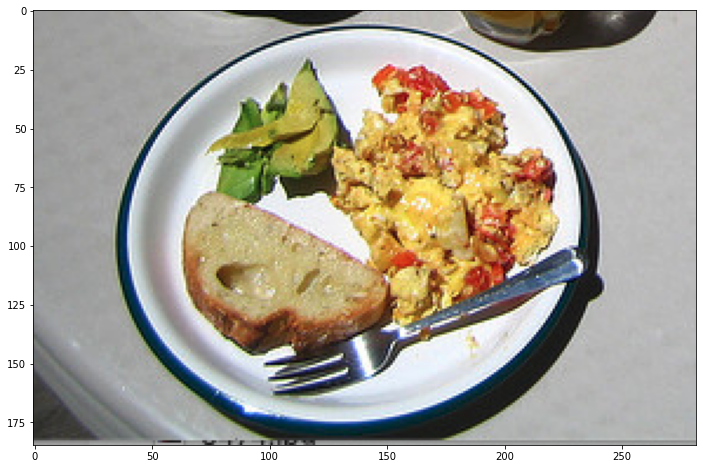

In [38]:
# import the image
# color_img = cv2.imread('0003.jpg', cv2.IMREAD_COLOR)
color_img = cv2.imread('6482.jpg', cv2.IMREAD_COLOR)
gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
cols, rows = gray_img.shape
# plt.figure(figsize=(12,8))
# plt.imshow(color_img)

# downsample the image
downsize = 1
cimg = cv2.resize(color_img, (np.int(rows/downsize), np.int(cols/downsize)))
gimg = cv2.resize(gray_img, (np.int(rows/downsize), np.int(cols/downsize)))
cols, rows = gimg.shape
plt.figure(figsize=(12,8))
plt.imshow(cimg)
# plt.imshow(gimg, cmap='gray')

## Edge Detection

In [39]:
def detect_edges(image, sigma, threshold):

  # calculate the derivative of Gaussian filter 
  image = image.astype(np.float)
  grad_x = gaussian_filter(image, order=(1,0), sigma=sigma)
  grad_y = gaussian_filter(image, order=(0,1), sigma=sigma)
  grad_mag = np.sqrt(grad_x ** 2 + grad_y **2)
  
  # nonmaximal suppression
  angle = np.arctan(grad_x/grad_y)
  edge_image = grad_mag.copy()
  p1 = 255; p2 = 255
  for i in range(1, angle.shape[0]-1):
      for j in range(1, angle.shape[1]-1):
          # find the pixels along the gradient direction 
          if (angle[i,j] >= -np.pi/8 and angle[i,j] < np.pi/8):
              p1 = grad_mag[i,j+1]
              p2 = grad_mag[i,j-1]
          elif (angle[i,j] >= -np.pi/8*3 and angle[i,j] < -np.pi/8):
              p1 = grad_mag[i-1,j+1]
              p2 = grad_mag[i+1,j-1]
          elif (angle[i,j] >= np.pi/8 and angle[i,j] < np.pi/8*3):
              p1 = grad_mag[i+1,j+1]
              p2 = grad_mag[i-1,j-1]
          elif (angle[i,j] >= -np.pi/2 and angle[i,j] < -np.pi/8*3) or \
              (angle[i,j] >= np.pi/8*3 and angle[i,j] < np.pi/2):
              p1 = grad_mag[i+1,j]
              p2 = grad_mag[i-1,j]
          # set the pixel (i,j) to be 0 if it is not the local maximum 
          if (grad_mag[i,j] < p1) or (grad_mag[i,j] < p2):
              edge_image[i,j] = 0

  # threshold the magnitudes 
  edge_image[edge_image < threshold] = 0
  edge_image[edge_image != 0] = 255
  edge_image = edge_image.astype(np.uint8)
  
  return edge_image

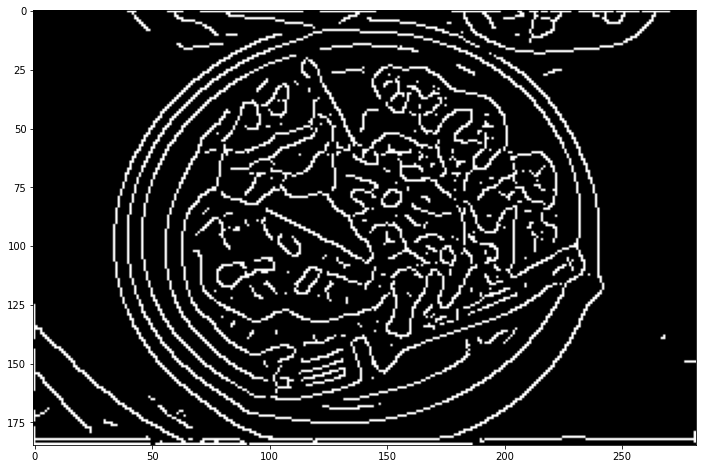

In [40]:
# edge image
# eimg = detect_edges(gimg, sigma=7.5, threshold=2.5)
eimg = detect_edges(gimg, sigma=2.5, threshold=1.0)
# eimg = cv2.Canny(gimg, 100, 250)
plt.figure(figsize=(12,8))
plt.imshow(eimg, cmap='gray')

## Hough Transform 

### Hough Contour

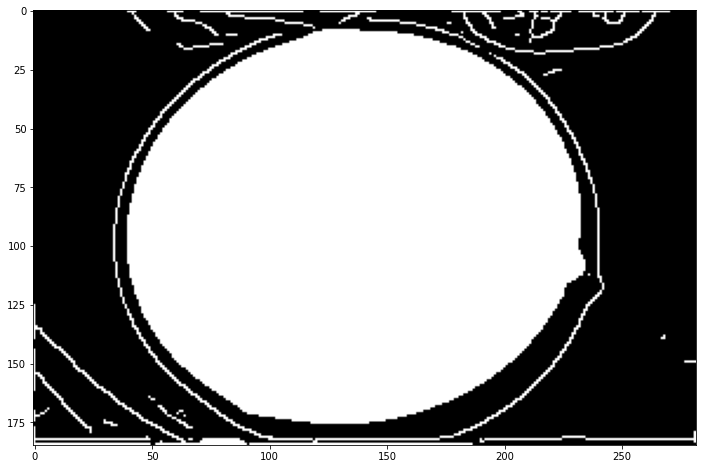

In [41]:
# find contours using hough transform
cnts = cv2.findContours(eimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
  cv2.drawContours(eimg, [c], 0, (255,255,255), thickness=cv2.FILLED)
plt.figure(figsize=(12,8))
plt.imshow(eimg, cmap='gray')

### Binary Image

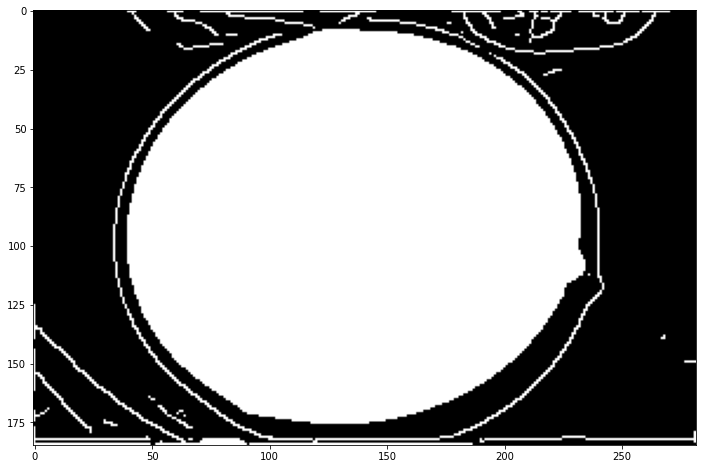

In [42]:
# binary image 
bimg = eimg.copy()
bimg[bimg == 255] = 1

plt.figure(figsize=(12,8))
plt.imshow(bimg, cmap='gray')

## Ellipse Attributes

### Center, Orientation, Roundedness

In [44]:
def get_attribute(bimg):
   
    ### ellipse from binary image
    rows, cols = bimg.shape
    ellipse = np.where(bimg == 1) 

    ### position
    center_x = np.mean(ellipse[1])
    center_y = rows - np.mean(ellipse[0])
    position = {"x": center_x, "y": center_y}

    ### orientation 
    
    # shift the coordinate system
    ellipse_new = np.array(ellipse).astype(np.float)
    ellipse_new[1,:] -= center_x
    ellipse_new[0,:] -= rows - center_y
        
    # calculate the second moments 
    a = np.sum(ellipse_new[0,:] ** 2)
    b = 2 * np.sum(ellipse_new[0,:] * ellipse_new[1,:])
    c = np.sum(ellipse_new[1,:] ** 2)
    
    # solve the theta for minimum and maximum E
    if (a-c == 0):
        theta_1 = np.arctan(b/1e-10) / 2
        theta_2 = theta_1 + np.pi / 2
    else:
        theta_1 = np.arctan(b/(a-c)) / 2
        theta_2 = theta_1 + np.pi / 2
    E_1 = a * np.square(np.sin(theta_1)) - \
          b * np.sin(theta_1) * np.cos(theta_1) + \
          c * np.square(np.cos(theta_1))
    E_2 = a * np.square(np.sin(theta_2)) - \
          b * np.sin(theta_2) * np.cos(theta_2) + \
          c * np.square(np.cos(theta_2))
    
    # determine the E_min and E_max 
    if (E_1 < E_2):
        theta = theta_1
        E_min = E_1
        E_max = E_2
    else:
        theta = theta_2
        E_min = E_2
        E_max = E_1
        
    # change the orientation from y-x based axis to x-y based axis
    if (theta > np.pi/2):
        theta -= np.pi/2
    else:
        theta += np.pi/2

    # roundedness
    roundedness = E_min / E_max
        
    # attribute 
    attribute = {'position': position, 'orientation': theta, 'roundedness': roundedness}

    return attribute

In [45]:
attribute = get_attribute(bimg)
print("Ellipse Attributes:\n", attribute)

Ellipse Attributes:
 {'position': {'x': 135.3438447765557, 'y': 92.314539408777}, 'orientation': 0.3305230163830353, 'roundedness': 0.7140678026046196}


### Major and Minor Axis

In [46]:
def draw_attributes(img, attribute):
    
    aimg = img.copy()
    rows = img.shape[0]

    center_x = (int)(attribute["position"]["x"])
    center_y = (int)(attribute["position"]["y"])
    slope_long = np.tan(attribute["orientation"])
    slope_short = np.tan(attribute["orientation"]+np.pi/2)

    # print(slope_long)
    # print(slope_short)
  
    # center of the ellipse
    cv2.circle(aimg, (center_x, rows - center_y), 2, (0, 255, 0), 2)
    # the long axis of the ellipse
    cv2.line(aimg, (center_x, rows - center_y), 
             (center_x + 1000, int(1000 * (-slope_long) + rows - center_y)), (0, 255, 0), 2)
    cv2.line(aimg, (center_x, rows - center_y),
            (center_x - 1000, int(-1000 * (-slope_long) + rows - center_y)), (0, 255, 0), 2)
    # the short axis of the ellipse
    cv2.line(aimg, (center_x, rows - center_y), 
            (center_x + 1000, int(1000 * (-slope_short) + rows - center_y)), (0, 255, 0), 2)
    cv2.line(aimg, (center_x, rows - center_y),
            (center_x - 1000, int(-1000 * (-slope_short) + rows - center_y)), (0, 255, 0), 2)
       
    return aimg

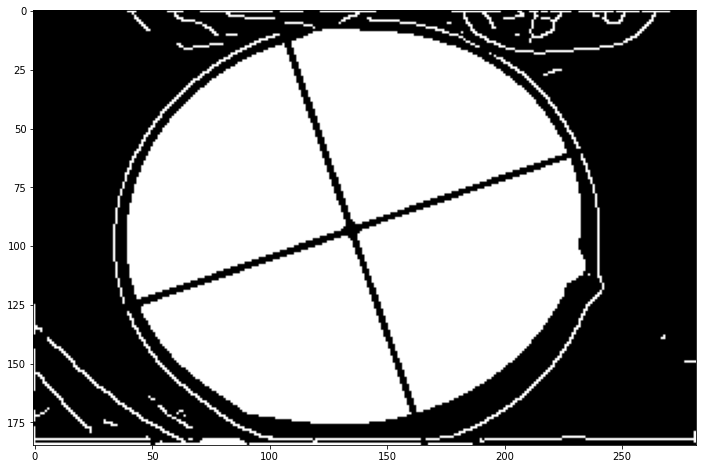

In [47]:
# attribute image
aimg = draw_attributes(bimg, attribute)
# aimg = draw_attributes(cimg, attribute)

plt.figure(figsize=(12,8))
# plt.imshow(aimg)
plt.imshow(aimg, cmap='gray')

### Corners

In [48]:
def find_corners(bimg, attribute):

    corners = []
    rows = bimg.shape[0]
    center_x = (int)(attribute["position"]["x"])
    center_y = (int)(attribute["position"]["y"])
    slope_long = np.tan(attribute["orientation"])
    slope_short = np.tan(attribute["orientation"]+np.pi/2)
    
    # find corners on the long axis of the ellipse
    for pos in np.arange(0.0, 1000.0, 0.1):
      x = int(center_x + pos)
      y = int(pos * (-slope_long) + rows - center_y)
      # print(y, x)
      if bimg[y][x] == 0:
        corners.append([x,y]) # corners.append([y,x])
        x = int(center_x - pos)
        y = int(-pos * (-slope_long) + rows - center_y)
        corners.append([x,y]) # corners.append([y,x])
        break

    # find corners on the short axis of the ellipse
    for pos in np.arange(0.0, 1000.0, 0.1):
      x = int(center_x + pos)
      y = int(pos * (-slope_short) + rows - center_y)
      # print(y, x)
      if bimg[y][x] == 0:
        corners.append([x,y]) # corners.append([y,x])
        x = int(center_x - pos)
        y = int(-pos * (-slope_short) + rows - center_y)
        corners.append([x,y]) # corners.append([y,x])
        break

    return corners

Ellipse Corners:
 [[228, 61], [42, 124], [162, 172], [107, 13]]


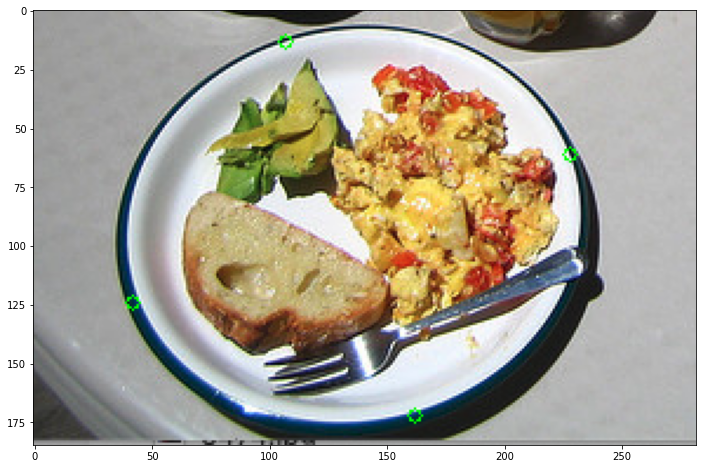

In [49]:
# find the corners of the ellipse
corners = find_corners(bimg, attribute)
print("Ellipse Corners:\n", corners)

cimg_copy = cimg.copy()
for c in corners:
   cv2.circle(cimg_copy, (c[0], c[1]), 3, (0, 255, 0))

plt.figure(figsize=(12,8))
plt.imshow(cimg_copy)

## Homography

In [52]:
def find_homography(corners, rows, cols):

  num_pts = len(corners)
  
  # source points
  source = np.zeros((num_pts,2))
  for i in range(num_pts):
    source[i,:] = corners[i]

  # target points
  target = np.zeros((num_pts,2)) 
  # target[0,:] = (rows, cols/2)
  # target[1,:] = (0, cols/2)
  # target[2,:] = (rows/2, cols)  
  # target[3,:] = (rows/2, 0)
  target[0,:] = (rows/4*3, cols/2)
  target[1,:] = (rows/4, cols/2)
  target[2,:] = (rows/2, cols/4*3)  
  target[3,:] = (rows/2, cols/4)

  # fill in the matrix A and vector b
  A = np.zeros((2*num_pts, 9))
  b = np.zeros((9, 1))
  for i in range(num_pts):
    A[2*i,:] = np.array([source[i][0], source[i][1], 1, 0, 0, 0, -target[i][0]*source[i][0], -target[i][0]*source[i][1],  -target[i][0]])
    A[2*i+1,:] = np.array([0, 0, 0, source[i][0], source[i][1], 1, -target[i][1]*source[i][0], -target[i][1]*source[i][1], -target[i][1]])

  # solve the eigenvector of A^{T}A with smallest eigenvalue 
  u, s, v = np.linalg.svd(np.transpose(A).dot(A))
  h = v[-1,:]
  h = h / np.linalg.norm(h) # unit vector
  # find the homography transformation matrix
  homography = h.reshape((3,3))
  homography /= homography[2,2]

  return homography

Homography Transformation Matrix:
 [[ 1.24423888e+00 -4.36548328e-01  1.29488111e+02]
 [ 4.99037208e-01  1.43416622e+00  5.64321298e+01]
 [ 3.91188376e-05 -3.75599166e-05  1.00000000e+00]]


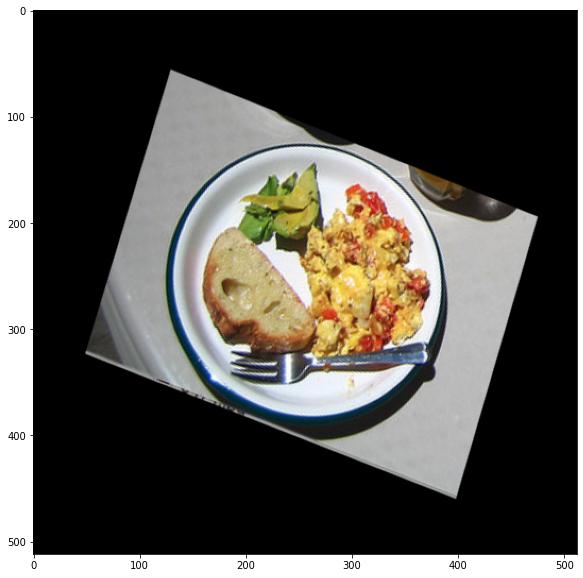

In [93]:
# find the homography matrix
# rows_output = 256; cols_output = 256 # the shapes for output image
rows_output = 512; cols_output = 512 # the shapes for output image
homography = find_homography(corners, rows_output, cols_output)
print("Homography Transformation Matrix:\n", homography)

# the output image 
oimg = cv2.warpPerspective(cimg, homography, (rows_output, cols_output))
plt.figure(figsize=(16,10))
plt.imshow(oimg)

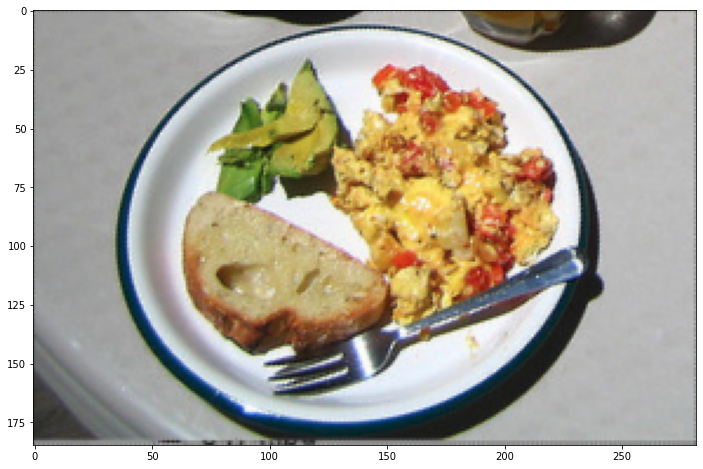

In [94]:
# the inverse image
iimg = cv2.warpPerspective(oimg, np.linalg.inv(homography), (rows, cols))
plt.figure(figsize=(12,8))
plt.imshow(iimg)

## Augmented Reality

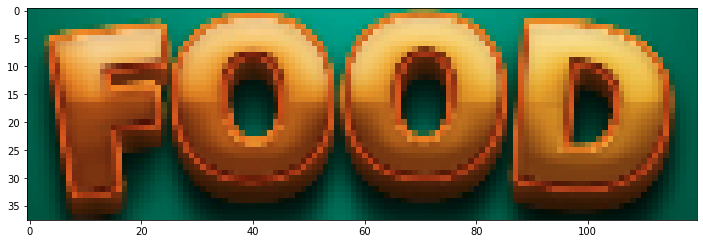

In [95]:
# import the image
# text = cv2.imread('food_text.png', cv2.IMREAD_COLOR)
text = cv2.imread('food_text2.png', cv2.IMREAD_COLOR)
ctext = cv2.cvtColor(text, cv2.COLOR_BGR2RGB)
cols_text, rows_text, _ = ctext.shape
# plt.figure(figsize=(12,8))
# plt.imshow(ctext)

# downsample the image
downsize = 4
ctext = cv2.resize(ctext, (np.int(rows_text/downsize), np.int(cols_text/downsize)))
cols_text, rows_text, _ = ctext.shape
plt.figure(figsize=(12,8))
plt.imshow(ctext)

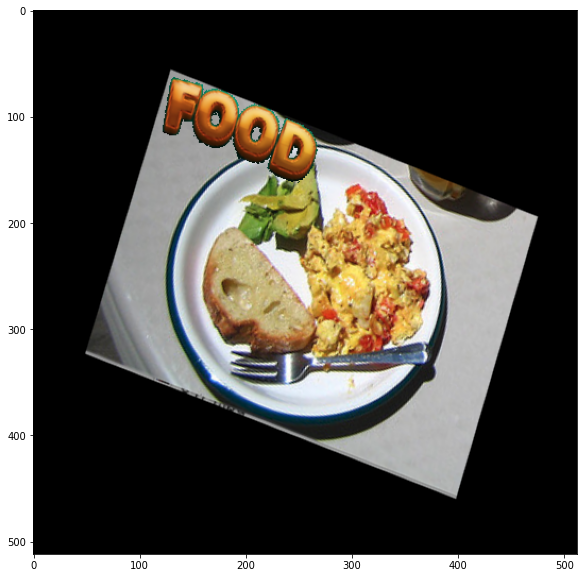

In [96]:
# the output image with text
otimg = oimg.copy()
otext = cv2.warpPerspective(ctext, homography, (rows_output, cols_output))
for i in range(rows_output):
  for j in range(cols_output):
    if (otext[i,j,0] != 0):
      otimg[i,j,:] = otext[i,j,:]
plt.figure(figsize=(16,10))
plt.imshow(otimg)

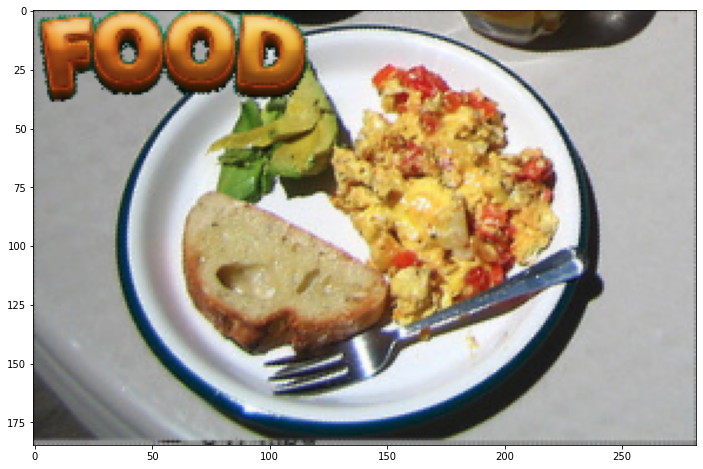

In [97]:
# the inverse image
iimg = cv2.warpPerspective(otimg, np.linalg.inv(homography), (rows, cols))
plt.figure(figsize=(12,8))
plt.imshow(iimg)

# All Code

In [ ]:
def detect_edges(image, sigma, threshold):

  # calculate the derivative of Gaussian filter 
  image = image.astype(np.float)
  grad_x = gaussian_filter(image, order=(1,0), sigma=sigma)
  grad_y = gaussian_filter(image, order=(0,1), sigma=sigma)
  grad_mag = np.sqrt(grad_x ** 2 + grad_y **2)
  
  # nonmaximal suppression
  angle = np.arctan(grad_x/grad_y)
  edge_image = grad_mag.copy()
  p1 = 255; p2 = 255
  for i in range(1, angle.shape[0]-1):
      for j in range(1, angle.shape[1]-1):
          # find the pixels along the gradient direction 
          if (angle[i,j] >= -np.pi/8 and angle[i,j] < np.pi/8):
              p1 = grad_mag[i,j+1]
              p2 = grad_mag[i,j-1]
          elif (angle[i,j] >= -np.pi/8*3 and angle[i,j] < -np.pi/8):
              p1 = grad_mag[i-1,j+1]
              p2 = grad_mag[i+1,j-1]
          elif (angle[i,j] >= np.pi/8 and angle[i,j] < np.pi/8*3):
              p1 = grad_mag[i+1,j+1]
              p2 = grad_mag[i-1,j-1]
          elif (angle[i,j] >= -np.pi/2 and angle[i,j] < -np.pi/8*3) or \
              (angle[i,j] >= np.pi/8*3 and angle[i,j] < np.pi/2):
              p1 = grad_mag[i+1,j]
              p2 = grad_mag[i-1,j]
          # set the pixel (i,j) to be 0 if it is not the local maximum 
          if (grad_mag[i,j] < p1) or (grad_mag[i,j] < p2):
              edge_image[i,j] = 0

  # threshold the magnitudes 
  edge_image[edge_image < threshold] = 0
  edge_image[edge_image != 0] = 255
  edge_image = edge_image.astype(np.uint8)
  
  return edge_image


def hough_transform(eimg):

  # find contours using hough transform
  cnts = cv2.findContours(eimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  for c in cnts:
    cv2.drawContours(eimg, [c], 0, (255,255,255), thickness=cv2.FILLED)

  # transform edge image to binary image 
  bimg = eimg.copy()
  bimg[bimg == 255] = 1
  
  return bimg


def get_attribute(bimg):
   
    ### ellipse from binary image
    rows, cols = bimg.shape
    ellipse = np.where(bimg == 1) 

    ### position
    center_x = np.mean(ellipse[1])
    center_y = rows - np.mean(ellipse[0])
    position = {"x": center_x, "y": center_y}

    ### orientation 
    
    # shift the coordinate system
    ellipse_new = np.array(ellipse).astype(np.float)
    ellipse_new[1,:] -= center_x
    ellipse_new[0,:] -= rows - center_y
        
    # calculate the second moments 
    a = np.sum(ellipse_new[0,:] ** 2)
    b = 2 * np.sum(ellipse_new[0,:] * ellipse_new[1,:])
    c = np.sum(ellipse_new[1,:] ** 2)
    
    # solve the theta for minimum and maximum E
    if (a-c == 0):
        theta_1 = np.arctan(b/1e-10) / 2
        theta_2 = theta_1 + np.pi / 2
    else:
        theta_1 = np.arctan(b/(a-c)) / 2
        theta_2 = theta_1 + np.pi / 2
    E_1 = a * np.square(np.sin(theta_1)) - \
          b * np.sin(theta_1) * np.cos(theta_1) + \
          c * np.square(np.cos(theta_1))
    E_2 = a * np.square(np.sin(theta_2)) - \
          b * np.sin(theta_2) * np.cos(theta_2) + \
          c * np.square(np.cos(theta_2))
    
    # determine the E_min and E_max 
    if (E_1 < E_2):
        theta = theta_1
        E_min = E_1
        E_max = E_2
    else:
        theta = theta_2
        E_min = E_2
        E_max = E_1
        
    # change the orientation from y-x based axis to x-y based axis
    if (theta > np.pi/2):
        theta -= np.pi/2
    else:
        theta += np.pi/2

    # roundedness
    roundedness = E_min / E_max
        
    # attribute 
    attribute = {'position': position, 'orientation': theta, 'roundedness': roundedness}

    return attribute


def draw_attributes(img, attribute):
    
    aimg = img.copy()
    rows = img.shape[0]

    center_x = (int)(attribute["position"]["x"])
    center_y = (int)(attribute["position"]["y"])
    slope_long = np.tan(attribute["orientation"])
    slope_short = np.tan(attribute["orientation"]+np.pi/2)

    # print(slope_long)
    # print(slope_short)
  
    # center of the ellipse
    cv2.circle(aimg, (center_x, rows - center_y), 2, (0, 255, 0), 2)
    # the long axis of the ellipse
    cv2.line(aimg, (center_x, rows - center_y), 
             (center_x + 1000, int(1000 * (-slope_long) + rows - center_y)), (0, 255, 0), 2)
    cv2.line(aimg, (center_x, rows - center_y),
            (center_x - 1000, int(-1000 * (-slope_long) + rows - center_y)), (0, 255, 0), 2)
    # the short axis of the ellipse
    cv2.line(aimg, (center_x, rows - center_y), 
            (center_x + 1000, int(1000 * (-slope_short) + rows - center_y)), (0, 255, 0), 2)
    cv2.line(aimg, (center_x, rows - center_y),
            (center_x - 1000, int(-1000 * (-slope_short) + rows - center_y)), (0, 255, 0), 2)
       
    return aimg


def find_corners(bimg, attribute):

    corners = []
    rows = bimg.shape[0]
    center_x = (int)(attribute["position"]["x"])
    center_y = (int)(attribute["position"]["y"])
    slope_long = np.tan(attribute["orientation"])
    slope_short = np.tan(attribute["orientation"]+np.pi/2)
    
    # find corners on the long axis of the ellipse
    for pos in np.arange(0.0, 1000.0, 0.1):
      x = int(center_x + pos)
      y = int(pos * (-slope_long) + rows - center_y)
      # print(y, x)
      if bimg[y][x] == 0:
        corners.append([x,y]) # corners.append([y,x])
        x = int(center_x - pos)
        y = int(-pos * (-slope_long) + rows - center_y)
        corners.append([x,y]) # corners.append([y,x])
        break

    # find corners on the short axis of the ellipse
    for pos in np.arange(0.0, 1000.0, 0.1):
      x = int(center_x + pos)
      y = int(pos * (-slope_short) + rows - center_y)
      # print(y, x)
      if bimg[y][x] == 0:
        corners.append([x,y]) # corners.append([y,x])
        x = int(center_x - pos)
        y = int(-pos * (-slope_short) + rows - center_y)
        corners.append([x,y]) # corners.append([y,x])
        break

    return corners


def find_homography(corners, rows, cols):

  num_pts = len(corners)
  
  # source points
  source = np.zeros((num_pts,2))
  for i in range(num_pts):
    source[i,:] = corners[i]

  # target points
  target = np.zeros((num_pts,2))
  target[0,:] = (rows, cols/2)
  target[1,:] = (0, cols/2)
  target[2,:] = (rows/2, cols)  
  target[3,:] = (rows/2, 0)

  # fill in the matrix A and vector b
  A = np.zeros((2*num_pts, 9))
  b = np.zeros((9, 1))
  for i in range(num_pts):
    A[2*i,:] = np.array([source[i][0], source[i][1], 1, 0, 0, 0, -target[i][0]*source[i][0], -target[i][0]*source[i][1],  -target[i][0]])
    A[2*i+1,:] = np.array([0, 0, 0, source[i][0], source[i][1], 1, -target[i][1]*source[i][0], -target[i][1]*source[i][1], -target[i][1]])

  # solve the eigenvector of A^{T}A with smallest eigenvalue 
  u, s, v = np.linalg.svd(np.transpose(A).dot(A))
  h = v[-1,:]
  h = h / np.linalg.norm(h) # unit vector
  # find the homography transformation matrix
  homography = h.reshape((3,3))
  homography /= homography[2,2]

  return homography

In [ ]:
def pose_estimation(img_name, downsize=1, sigma=2.5, threshold=1.0, rows_output=256, cols_output=256):

  ### image preprocessing
  color_img = cv2.imread(img_name, cv2.IMREAD_COLOR)
  gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
  color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
  cols, rows = gray_img.shape
  # downsample the image
  cimg = cv2.resize(color_img, (np.int(rows/downsize), np.int(cols/downsize)))
  gimg = cv2.resize(gray_img, (np.int(rows/downsize), np.int(cols/downsize)))
  cols, rows = gimg.shape
  plt.figure(figsize=(12,8))
  plt.imshow(cimg)

  ### edge detection
  eimg = detect_edges(gimg, sigma, threshold)
  plt.figure(figsize=(12,8))
  plt.imshow(eimg, cmap='gray')

  ### hough transform
  bimg = hough_transform(eimg)
  plt.figure(figsize=(12,8))
  plt.imshow(bimg, cmap='gray')

  ### ellipse attributes
  attribute = get_attribute(bimg)
  print("Ellipse Attributes:\n", attribute)
  # attribute image
  aimg = draw_attributes(bimg, attribute)
  plt.figure(figsize=(12,8))
  plt.imshow(aimg, cmap='gray')
  # find corners 
  corners = find_corners(bimg, attribute)
  print("Ellipse Corners:\n", corners)
  cimg_copy = cimg.copy()
  for c in corners:
    cv2.circle(cimg_copy, (c[0], c[1]), 3, (0, 255, 0))
  plt.figure(figsize=(12,8))
  plt.imshow(cimg_copy)
  
  ### find homography 
  homography = find_homography(corners, rows_output, cols_output)
  print("Homography Transformation Matrix:\n", homography)
  # the output image 
  oimg = cv2.warpPerspective(cimg, homography, (rows_output, cols_output))
  plt.figure(figsize=(12,8))
  plt.imshow(oimg)
  # the inverse image
  iimg = cv2.warpPerspective(oimg, np.linalg.inv(homography), (rows, cols))
  plt.figure(figsize=(12,8))
  plt.imshow(iimg)
  
  return 0

## Test

### 298.jpg

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Ellipse Attributes:
 {'position': {'x': 164.90535095320624, 'y': 121.86902079722704}, 'orientation': 3.0131453369937145, 'roundedness': 0.4389978529833273}
Ellipse Corners:
 [[313, 138], [15, 99], [176, 21], [151, 216]]
Homography Transformation Matrix:
 [[ 8.51435103e-01  1.10028846e-01 -2.36643823e+01]
 [ 1.72436523e-01 -1.29582918e+00  2.53861188e+02]
 [ 2.10085736e-05  9.49418516e-06  1.00000000e+00]]


0

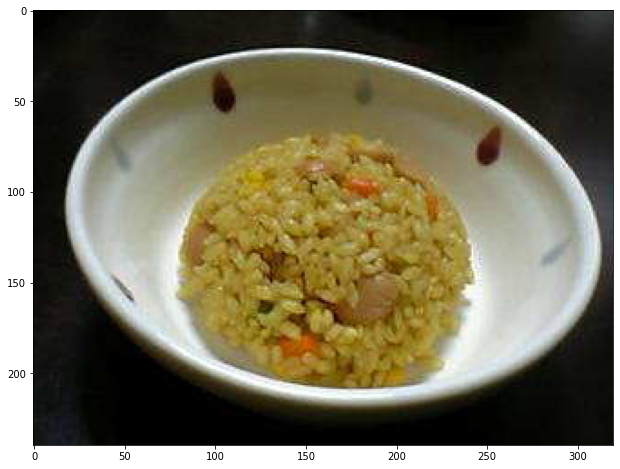

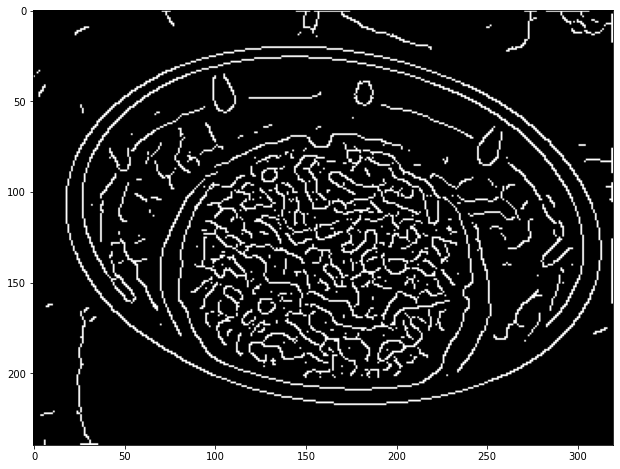

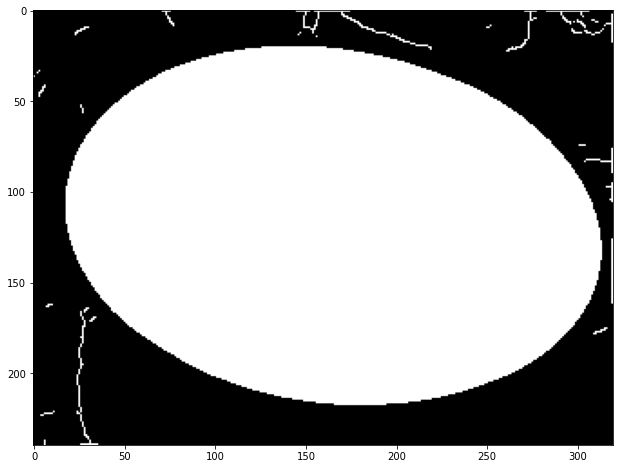

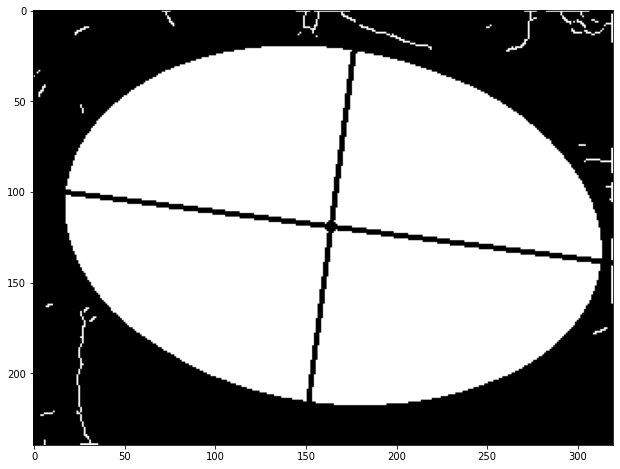

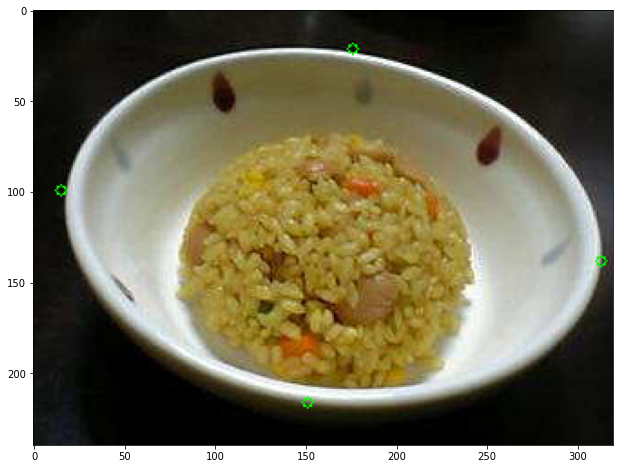

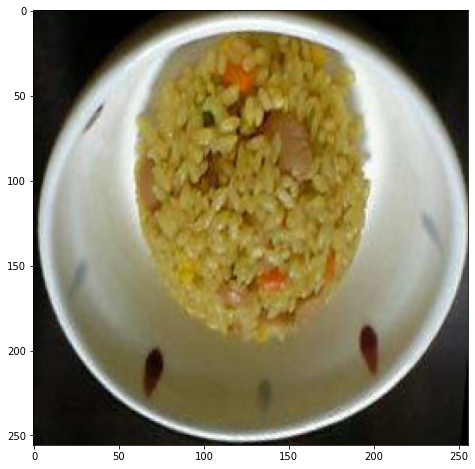

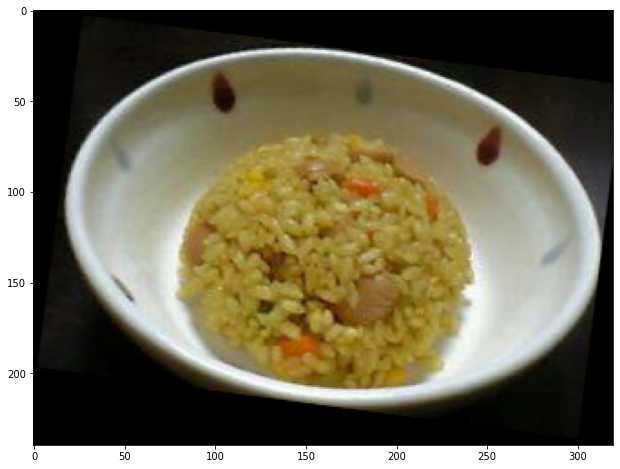

In [ ]:
pose_estimation(img_name='298.jpg', downsize=1, sigma=2.5, threshold=1.0, rows_output=256, cols_output=256)

### 573.jpg

Ellipse Attributes:
 {'position': {'x': 153.42088386564225, 'y': 124.22334751412788}, 'orientation': 0.17057724007845332, 'roundedness': 0.44740234253200256}
Ellipse Corners:
 [[270, 95], [36, 136], [165, 189], [140, 42]]
Homography Transformation Matrix:
 [[ 1.06901013e+00 -1.83824974e-01 -1.34841683e+01]
 [ 3.01093393e-01  1.69246145e+00 -1.13236456e+02]
 [ 3.18401123e-05 -2.12003730e-05  1.00000000e+00]]


0

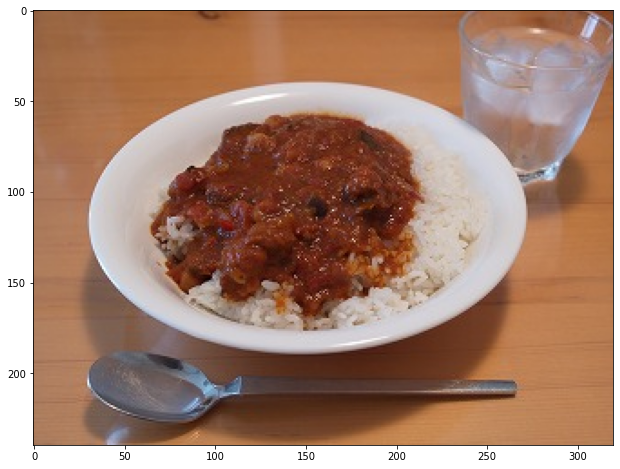

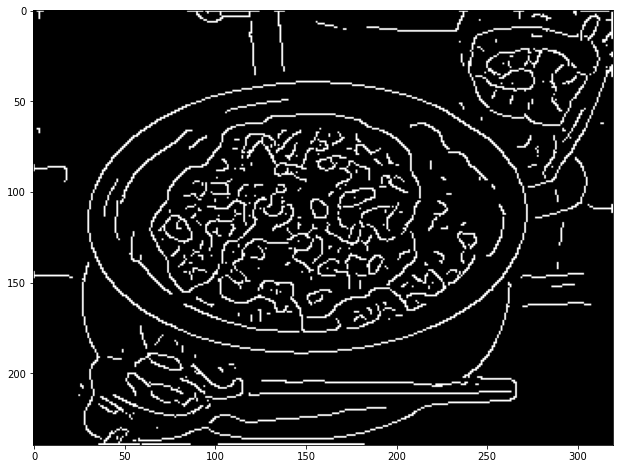

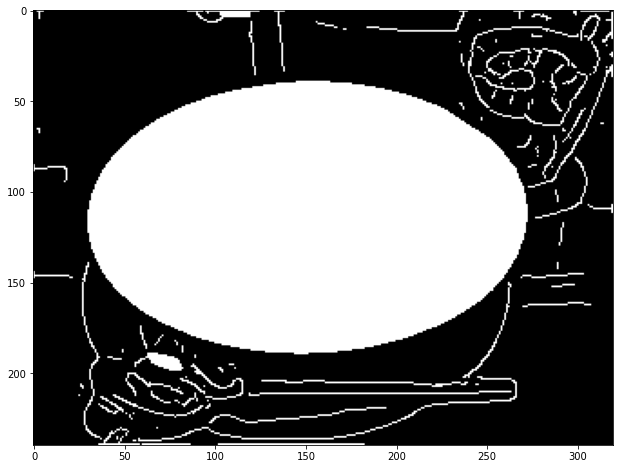

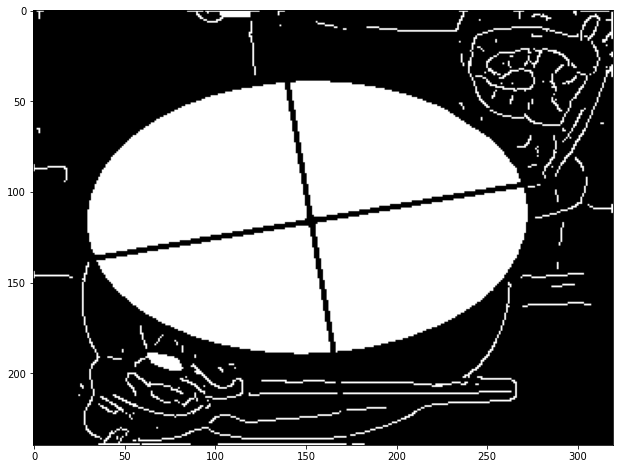

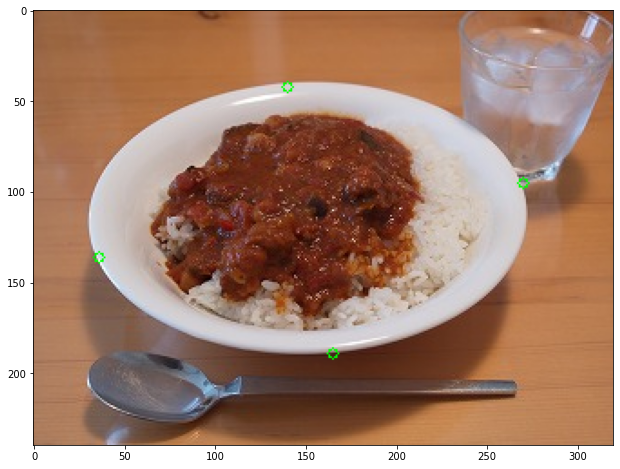

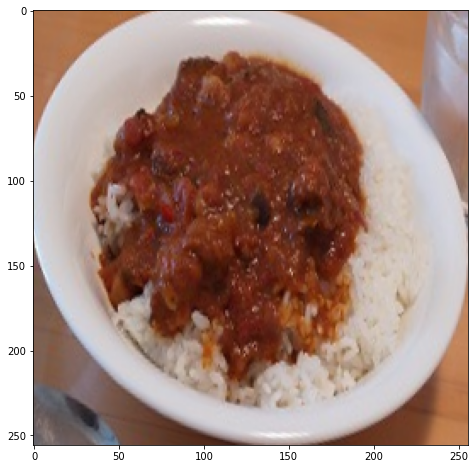

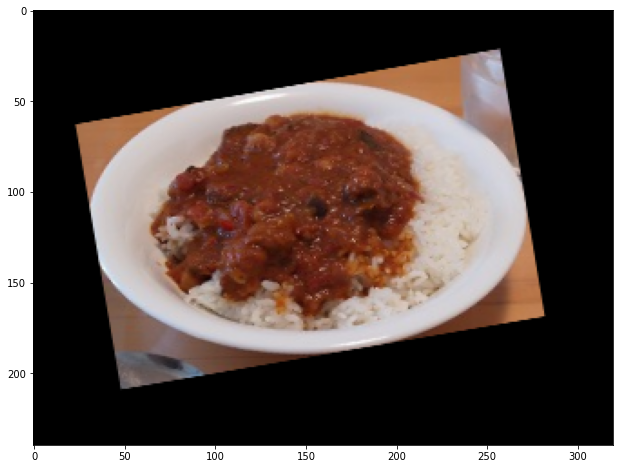

In [ ]:
pose_estimation(img_name='573.jpg', downsize=1, sigma=2.5, threshold=1.0, rows_output=256, cols_output=256)

### 1917.jpg

Ellipse Attributes:
 {'position': {'x': 192.03751169186526, 'y': 154.06895059401657}, 'orientation': 3.1332199896204225, 'roundedness': 0.7272378705165656}
Ellipse Corners:
 [[356, 147], [28, 144], [193, 2], [190, 289]]
Homography Transformation Matrix:
 [[ 7.85642960e-01  8.24082281e-03 -2.31846814e+01]
 [ 1.05747482e-02 -8.95087313e-01  2.56671031e+02]
 [ 1.86522253e-05  4.17838639e-07  1.00000000e+00]]


0

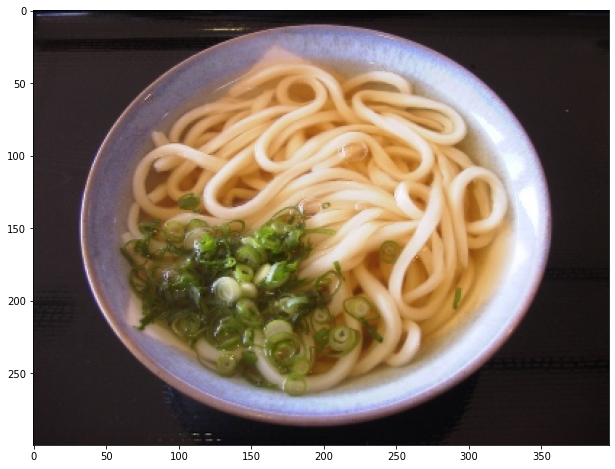

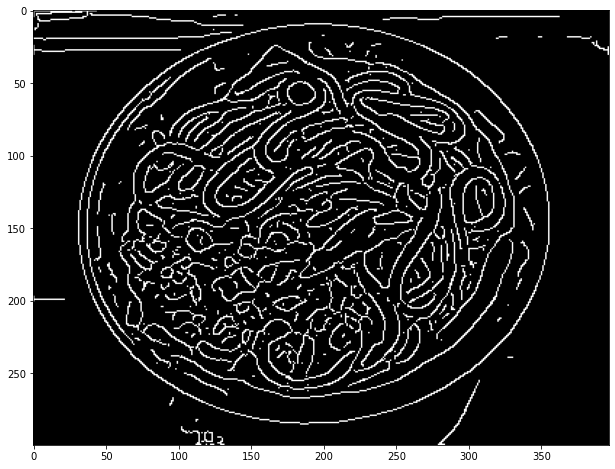

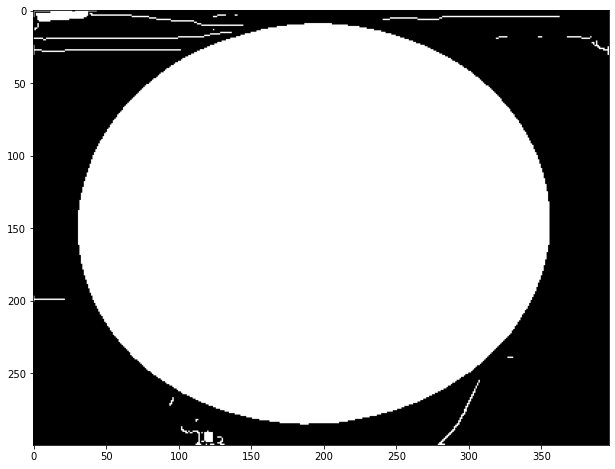

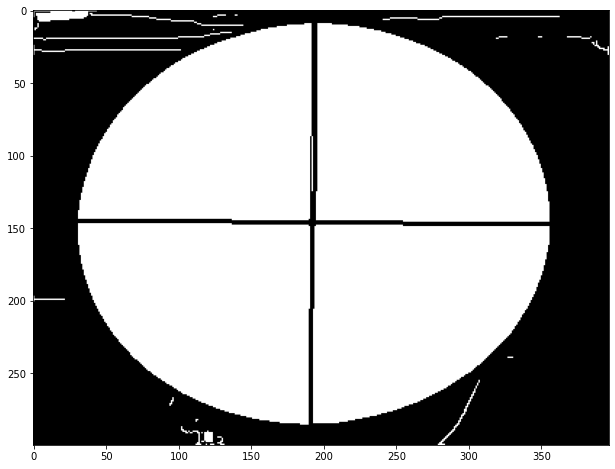

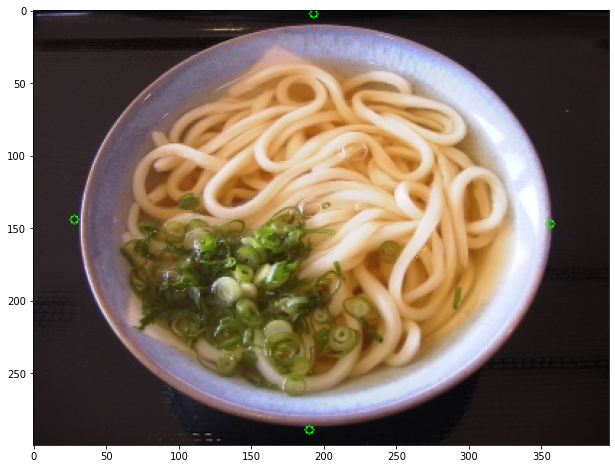

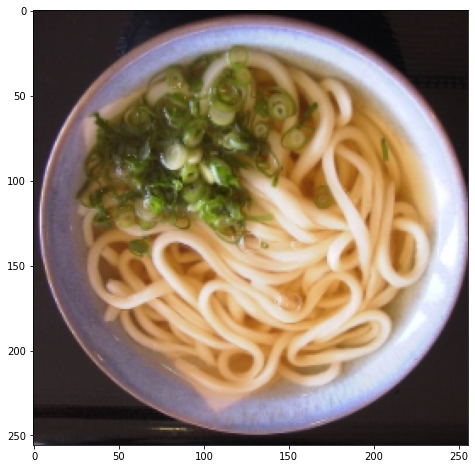

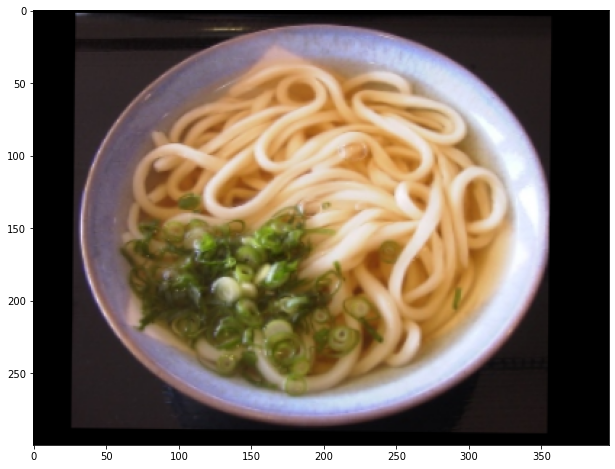

In [ ]:
pose_estimation(img_name='1917.jpg', downsize=1, sigma=2.5, threshold=1.0, rows_output=256, cols_output=256)